In [117]:
import numpy as np
import pandas as pd

import bct
import glob
import os
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt


from pathlib import Path
np.set_printoptions(suppress=True)

In [3]:
def module_nodes(modules, module):
    nodes = []
    
    for (key, value) in modules.items():
        if value == module:
            nodes.append(key)
            
    return nodes

In [4]:
def relative_degree(grid, nodes, node):
    all_nodes = nodes
    if not np.isin(node, nodes):
        all_nodes.append(node)
    
    return (grid.subgraph(nodes).degree(node))

In [5]:
def global_degree(node, grid):
    return(grid.degree(node))

In [6]:
def participation_coefficient(grid, modules, node):
    acum = 0
    number_of_modules = len(set(list(modules.values())))
    
    for module in range(1,number_of_modules):
        relative_degree_value = relative_degree(grid, module_nodes(modules, module), node)
        global_degree_value = global_degree(node, grid)        
        
        if global_degree_value > 0:
            acum = pow(relative_degree_value / global_degree_value, 2)
        else:
            #print("Global degree zero for node %s and module %s", node, module)
            acum = 0
            
    return (1-acum)        

In [7]:
def intra_modular_degree_zscore(grid, modules, node):
    module = modules[node]    
    nodes = module_nodes(modules, module)
    relative_degrees = {}
    
    for  node in nodes:
        relative_degrees[node] = relative_degree(grid, nodes, node)
    
    im_degree = relative_degrees[node]
    degrees_values = list(relative_degrees.values())
    im_mean = np.mean(degrees_values)        
    im_std_deviation = np.std(degrees_values)
    
    if im_std_deviation > 0:
        return ((im_degree - im_mean) / im_std_deviation)
    else:
        return (0)
    

In [8]:
def node_clasfication(P_c, Z_c, P_i, Z_i):
    if (P_i >= P_c and Z_i >= Z_c):
        return("hub")
    if (P_i <= P_c and Z_i >= Z_c):
        return("provincial_hub")
    if (P_i <= P_c and Z_i <= Z_c):
        return("provincial_node")
    if (P_i >= P_c and Z_i <= Z_c):
        return("connector_node")
    

In [9]:
def node_roles(G, P_c, Z_c):
    result = {}
    roles = []
    modules = community_louvain.best_partition(G)

    for node in G.nodes():
        Z_i = intra_modular_degree_zscore(G, modules, node)
        P_i = participation_coefficient(G, modules, node)
        role = node_clasfication(P_c, Z_c, P_i, Z_i)        
        result[node] = list([Z_i, P_i, role])
        roles.append(role)
    
    return([result, roles])

In [10]:
def grid_roles(G, P_c, Z_c):
    roles_stats, roles = node_roles(G, P_c, Z_c)
    unique_roles, counts = np.unique(roles, return_counts=True)
    
    result = {"hub" : 0,
              "provincial_hub": 0,
              "provincial_node": 0,
              "connector_node": 0}
    
    for i in range(0, len(unique_roles)):
        result[unique_roles[i]] = counts[i]
        
    return (result)
    

In [11]:
def subjectmatrix_to_graphs(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
    """

    correlation_matrix = pd.read_csv(
        filename,
        header=None
    )
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(
        correlation_matrix.values[tril_idx].flatten(),
        reverse=True
    )

    #Gs = []
    Gs = {}
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        #Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        Gs[d] = nx.from_pandas_adjacency(correlation_matrix>=threshold)

    return Gs

In [12]:
def extract_graphs(tipo_red, densities):

    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + "/{}_suj*.csv".format(tipo_red))


    graphs = {}
    for filename in all_files:
        Gs = subjectmatrix_to_graphs(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs

    return graphs

In [22]:
densities = np.linspace(0.025,0.15)

G_N1 = extract_graphs("N1", densities)
G_N2 = extract_graphs("N2", densities)
G_N3 = extract_graphs("N3", densities)
G_W = extract_graphs("W", densities)

In [78]:
def roles_per_state(Gs):
    roles = []
    for (sub, gs) in G_N1.items():
        for (density, g) in gs.items():
            grid_roles_values = grid_roles(g, 0.05, 1)
            roles.append([density, grid_roles_values["hub"]
                            , grid_roles_values["provincial_hub"]
                            , grid_roles_values["provincial_node"]
                            , grid_roles_values["connector_node"]])
    #return (np.array(roles, dtype=[('density', float), ('hub', int), ('provincial_hub', int), ('provincial_node', int), ('connector_node', int)]))
    return (np.array(roles))

In [105]:
def agregate_per_density(roles):
    densities = np.linspace(0.025,0.15)
    result = []
        
    for d in densities:
        density_filter = np.asarray([d])
        by_density = roles[np.in1d(roles[:, 0], density_filter)]
        result.append(np.mean(by_density, axis=0))
        
    return (np.array(result))

            

In [79]:
roles_N1 = roles_per_state(G_N1)

In [108]:
roles_N2 = roles_per_state(G_N2)

In [109]:
roles_N3 = roles_per_state(G_N3)

In [110]:
roles_W = roles_per_state(G_W)

In [111]:
roles_mean_N1 = agregate_per_density(roles_N1)

In [112]:
roles_mean_N2 = agregate_per_density(roles_N2)

In [113]:
roles_mean_N3 = agregate_per_density(roles_N3)

Text(0, 0.5, 'Hubs')

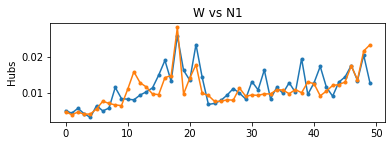

In [120]:
plt.subplot(211)   
plt.plot(densities/roles_mean_N1[:, 1],'.-')
plt.plot(densities/roles_mean_W[:, 1],'.-')
plt.title('W vs N1')
plt.ylabel('Hubs')

